# Linear Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import glob
import pickle
import time

np.random.seed(42)

## Load Data

In [2]:
input_files = sorted(glob.glob('data/train/input_*.csv'))
output_files = sorted(glob.glob('data/train/output_*.csv'))

input_dfs = [pd.read_csv(f) for f in input_files]
output_dfs = [pd.read_csv(f) for f in output_files]

input_df = pd.concat(input_dfs, ignore_index=True)
output_df = pd.concat(output_dfs, ignore_index=True)

print(f'Loaded {len(input_files)} weeks')
print(f'Input: {input_df.shape}, Output: {output_df.shape}')

Loaded 18 weeks
Input: (4880579, 23), Output: (562936, 6)


## Feature Engineering

In [3]:
# Parse height "6-1" -> 73 inches
input_df['player_height_inches'] = input_df['player_height'].str.split('-').apply(
    lambda x: int(x[0])*12 + int(x[1]) if isinstance(x, list) and len(x)==2 else np.nan
)

# Calculate age
input_df['player_age'] = 2023 - pd.to_datetime(input_df['player_birth_date']).dt.year

# Encode categorical variables
encoders = {}
for col in ['player_position', 'player_side', 'player_role', 'play_direction']:
    encoders[col] = LabelEncoder()
    input_df[f'{col}_enc'] = encoders[col].fit_transform(input_df[col].fillna('Unknown'))

print('Features engineered')

Features engineered


## Merge and Prepare Features

In [4]:
df = input_df.merge(output_df, on=['game_id', 'play_id', 'nfl_id'], suffixes=('', '_target'))

# All 19 features
features = [
    'x', 'y', 's', 'a', 'dir', 'o',
    'ball_land_x', 'ball_land_y',
    'absolute_yardline_number',
    'player_height_inches', 'player_weight', 'player_age',
    'player_position_enc', 'player_side_enc', 'player_role_enc', 'play_direction_enc',
    'frame_id', 'num_frames_output',
    'player_to_predict'
]

X = df[features].fillna(0).astype(float)
y = df[['x_target', 'y_target']]

print(f'Features: {X.shape[1]}')
print(f'Samples: {len(X):,}')

Features: 19
Samples: 16,534,398


## Split and Scale

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Train: {len(X_train):,}, Test: {len(X_test):,}')

Train: 13,227,518, Test: 3,306,880


## Train Model

In [6]:
model = LinearRegression(n_jobs=-1)

start = time.time()
model.fit(X_train_scaled, y_train)
train_time = time.time() - start

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print(f'Training time: {train_time:.2f}s')

Training time: 2.80s


## Metrics

In [7]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

errors = np.sqrt(np.sum((y_test.values - y_test_pred)**2, axis=1))
mean_error = errors.mean()

print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE:  {test_rmse:.4f}')
print(f'Train R²:   {train_r2:.4f}')
print(f'Test R²:    {test_r2:.4f}')
print(f'Mean Error: {mean_error:.4f} yards')

Train RMSE: 4.8157
Test RMSE:  4.8121
Train R²:   0.9210
Test R²:    0.9210
Mean Error: 5.6173 yards


## Feature Importance

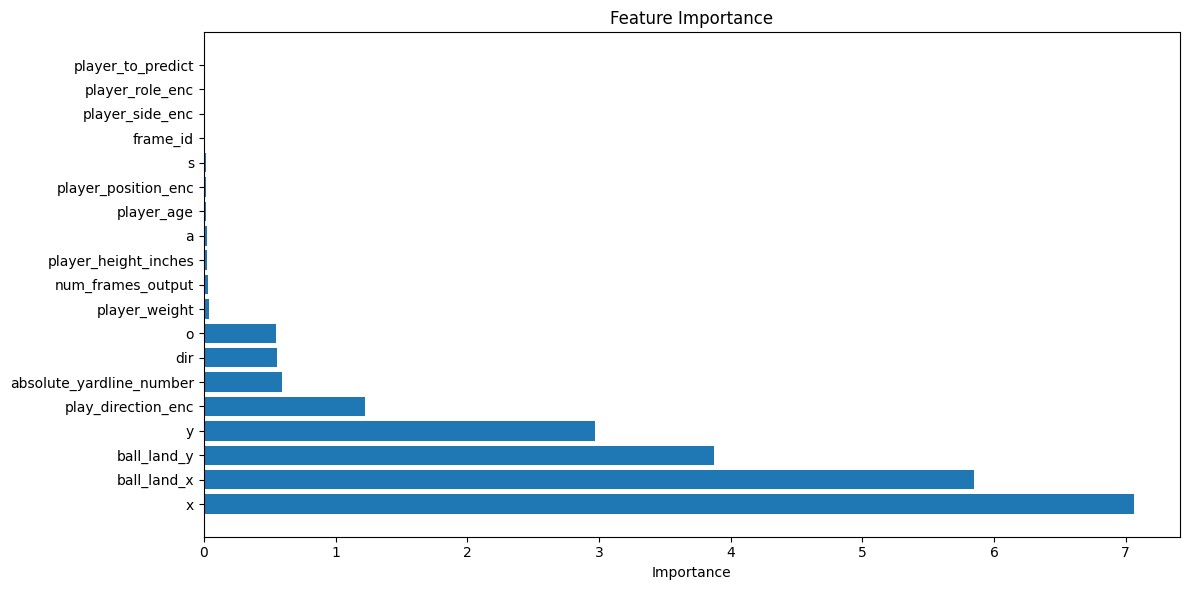


Top 10 Features:
                     feature  importance
0                          x    7.059597
6                ball_land_x    5.848943
7                ball_land_y    3.873096
1                          y    2.973498
15        play_direction_enc    1.224056
8   absolute_yardline_number    0.589699
4                        dir    0.552519
5                          o    0.549694
10             player_weight    0.040888
17         num_frames_output    0.033223


In [8]:
importance = (np.abs(model.coef_[0]) + np.abs(model.coef_[1])) / 2
feat_imp = pd.DataFrame({'feature': features, 'importance': importance}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig('graphs/linear_regression_feature_importance.png', dpi=300)
plt.show()

print('\nTop 10 Features:')
print(feat_imp.head(10))

## Predictions

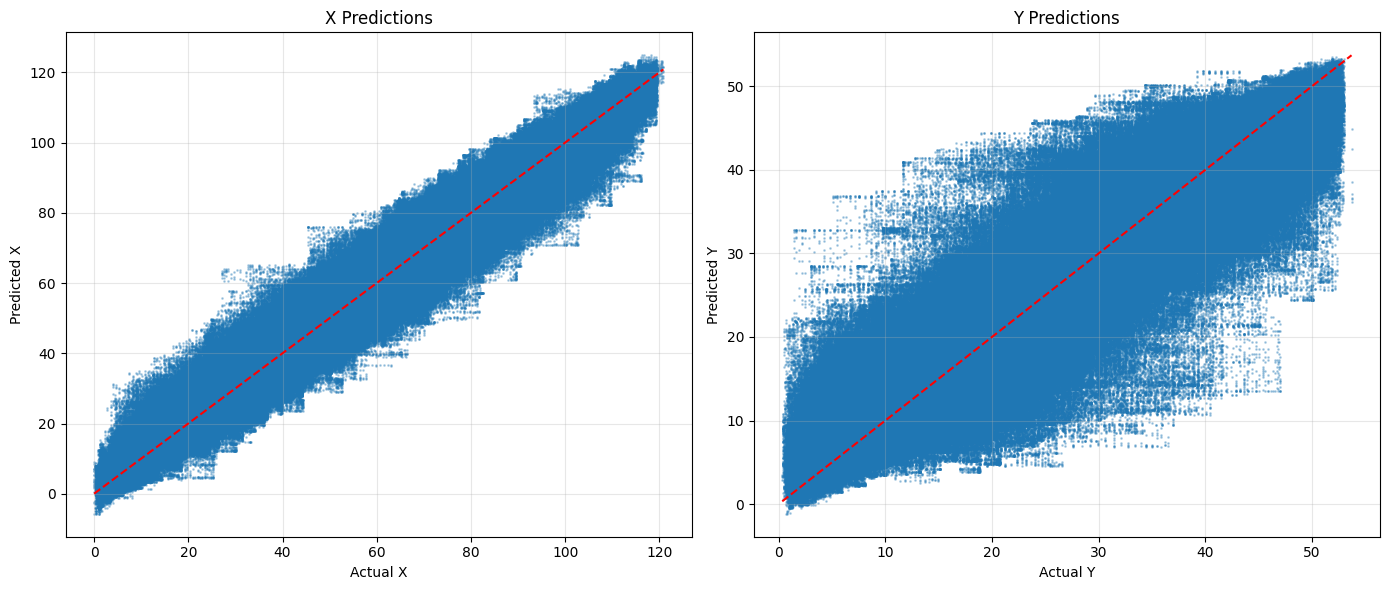

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_test.iloc[:, 0], y_test_pred[:, 0], alpha=0.3, s=1)
axes[0].plot([y_test.iloc[:, 0].min(), y_test.iloc[:, 0].max()], 
             [y_test.iloc[:, 0].min(), y_test.iloc[:, 0].max()], 'r--')
axes[0].set_xlabel('Actual X')
axes[0].set_ylabel('Predicted X')
axes[0].set_title('X Predictions')
axes[0].grid(alpha=0.3)

axes[1].scatter(y_test.iloc[:, 1], y_test_pred[:, 1], alpha=0.3, s=1)
axes[1].plot([y_test.iloc[:, 1].min(), y_test.iloc[:, 1].max()], 
             [y_test.iloc[:, 1].min(), y_test.iloc[:, 1].max()], 'r--')
axes[1].set_xlabel('Actual Y')
axes[1].set_ylabel('Predicted Y')
axes[1].set_title('Y Predictions')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('graphs/linear_regression_predictions.png', dpi=300)
plt.show()

## Error Distribution

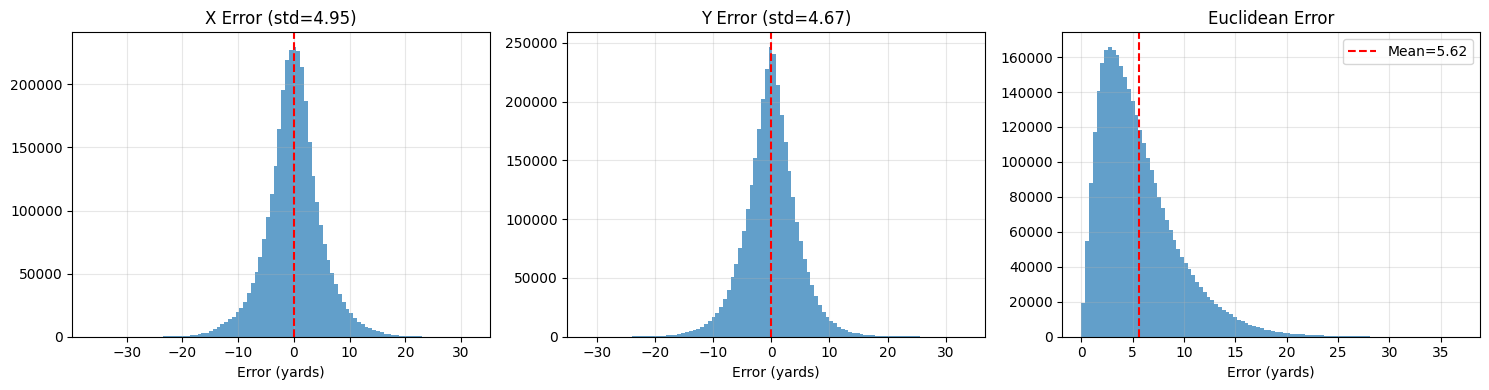

In [10]:
errors_x = y_test.iloc[:, 0].values - y_test_pred[:, 0]
errors_y = y_test.iloc[:, 1].values - y_test_pred[:, 1]
errors_euclidean = np.sqrt(errors_x**2 + errors_y**2)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(errors_x, bins=100, alpha=0.7)
axes[0].axvline(0, color='r', linestyle='--')
axes[0].set_xlabel('Error (yards)')
axes[0].set_title(f'X Error (std={np.std(errors_x):.2f})')
axes[0].grid(alpha=0.3)

axes[1].hist(errors_y, bins=100, alpha=0.7)
axes[1].axvline(0, color='r', linestyle='--')
axes[1].set_xlabel('Error (yards)')
axes[1].set_title(f'Y Error (std={np.std(errors_y):.2f})')
axes[1].grid(alpha=0.3)

axes[2].hist(errors_euclidean, bins=100, alpha=0.7)
axes[2].axvline(mean_error, color='r', linestyle='--', label=f'Mean={mean_error:.2f}')
axes[2].set_xlabel('Error (yards)')
axes[2].set_title('Euclidean Error')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('graphs/linear_regression_error_distribution.png', dpi=300)
plt.show()

## Save Model

In [11]:
model_data = {
    'model': model,
    'scaler': scaler,
    'encoders': encoders,
    'features': features,
    'metrics': {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'mean_error': mean_error
    }
}

with open('models/linear_regression_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print('Model saved to models/linear_regression_model.pkl')

Model saved to models/linear_regression_model.pkl
